<a href="https://colab.research.google.com/github/dmitriy-iliyov/data-science/blob/main/general/lab_6/notebook/data_sience_lab_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time

import tensorflow as tf


import numpy as np
import datetime
import requests
import pandas as pd


def coin_parsing(currency, days=90, interval='hourly'):

    test_url = 'https://api.coingecko.com/api/v3/coins/' + currency
    test_response = requests.get(test_url)

    if test_response.status_code == 200:

        print('Test request successful')
        url = test_url + '/market_chart'

        params = {
            'vs_currency': 'usd',
            'days': days
        }

        if interval != 'hourly':
            params['interval'] = interval

        response = requests.get(url, params=params)

        coin_year_prices = response.json()
        dates = []
        prices = []

        for daily_price in coin_year_prices['prices']:
            dates.append(datetime.datetime.fromtimestamp(daily_price[0] / 1000))
            prices.append(daily_price[1])
        coin_year_prices_df = pd.DataFrame({'date': dates, 'price': prices})

        print('Coin parsing successful')
        return coin_year_prices_df
    else:
        print('Test request failed, status code ' + str(test_response.status_code))
        print(test_response.text)
        return None


In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))


def prepare_data(currency):

    df = coin_parsing(currency, 90)
    prices = df['price']

    prices_scaled = scaler.fit_transform(prices.values.reshape(-1, 1))

    print(f"Prices scaled shape: {prices_scaled.shape}")

    time_step = 24
    features = 1
    train_data = []
    train_answ = []

    for i in range(len(prices_scaled) - time_step):
        train_data.append(prices_scaled[i:i + time_step])
        train_answ.append(prices_scaled[i + time_step])


    train_data = np.array(train_data, dtype=np.float32)
    train_answ = np.array(train_answ, dtype=np.float32)

    k = int(train_data.shape[0] * 0.8)
    train_data, test_data = train_data[:k], train_data[k:]
    train_answ, test_answ = train_answ[:k], train_answ[k:]

    train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], features)
    test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], features)

    return train_data, train_answ, test_data, test_answ

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input, LSTM
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping


from google.colab import drive
drive.mount('/content/drive')


class KerasLSTM:

    def __init__(self):
        self._model = Sequential([
            Input(shape=(24, 1)),
            LSTM(128, activation='tanh', return_sequences=True),
            LSTM(64, activation='tanh', return_sequences=False),
            Dense(1, activation='linear')
        ])
        self._model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

        self._model_dir = '/content/drive/MyDrive/data_science/lab_6/bitcoin_model'

    def summary(self):
        self._model.summary()

    def fit(self, train_data, train_answers, validation_split=0.1, epochs=100, batch_size=32):
        start_time = time.time()
        early_stopping = EarlyStopping(
            monitor='val_mae',
            patience=5,
            restore_best_weights=True
        )
        history = self._model.fit(
            train_data, train_answers,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks = [early_stopping],
            verbose=1
        )
        self._model.save(self._model_dir + '/lstm_bitcoin_model.keras')
        execution_time = time.time() - start_time
        print(f"Training completed in {execution_time:.2f} seconds.")
        self.plot_history(history, execution_time)
        return history, execution_time

    def evaluate(self, test_data, test_answers):
        test_loss, test_mae = self._model.evaluate(test_data, test_answers, verbose=1)
        return test_loss, test_mae

    def predict(self, sequence):
        return self._model.predict(sequence)

    @staticmethod
    def plot_history(history, execution_time):
        epochs = len(history.history['mae'])
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), history.history['mae'], label='Training MAE')
        if 'val_mae' in history.history:
            plt.plot(range(1, epochs + 1), history.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.title(f'MAE (Execution Time: {execution_time:.2f} seconds)')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Test request successful
Coin parsing successful
Prices scaled shape: (2159, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 24, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0122 - mae: 0.0740 - val_loss: 4.2127e-04 - val_mae: 0.0160
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0925e-04 - mae: 0.0138 - val_loss: 3.1983e-04 - val_mae: 0.0144
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7293e-04 - mae: 0.0113 - val_loss: 3.1574e-04 - val_mae: 0.0143
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6273e-04 - mae: 0.0111 - val_loss: 4.3702e-04 - val_mae: 0.0163
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3154e-04 - mae: 0.0104 - val_loss: 2.8624e-04 - val_mae: 0.0133
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6064e-04 - mae: 0.0107 - val_loss: 4.3527e-04 - val_mae: 0.0163
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3189e-04 - mae: 0.0107 - val_loss: 8.6764e-04 - val_mae: 0.0248
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8802e-04 - mae: 0.0119 - val_loss: 5.4071e-04 - val_mae: 0.0184
Epo

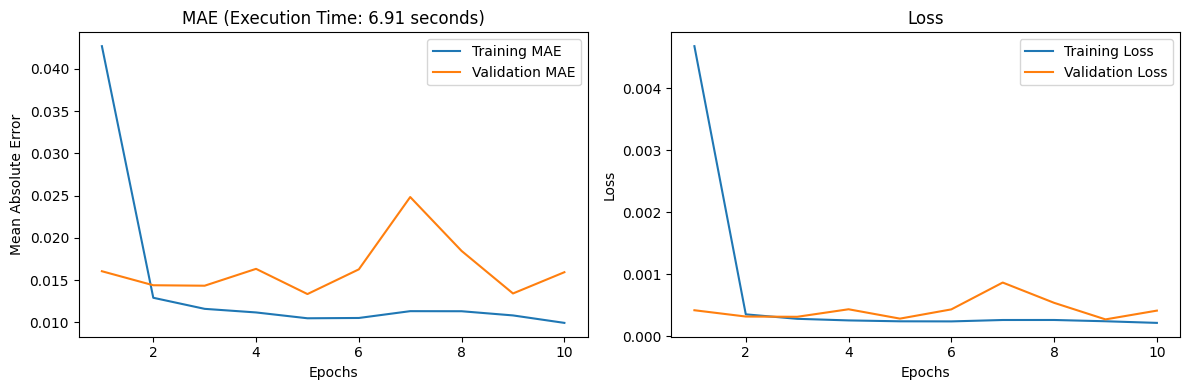

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7413e-04 - mae: 0.0157 
Test request successful
Coin parsing successful
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Predicted price: 100117.5234375
Actual price: 99467.41882642455


In [12]:
with tf.device('/GPU:0'):
  train_data, train_answers, test_data, test_answers = prepare_data("bitcoin")

  lstm = KerasLSTM()
  lstm.summary()

  lstm.fit(train_data, train_answers)

  lstm.evaluate(test_data, test_answers)

  last_48_hour = coin_parsing('bitcoin', 2)
  sequence = last_48_hour['price'][:24]
  sequence_scaled = scaler.transform(np.array(sequence).reshape(-1, 1)).reshape(1, 24, 1)

  prediction = lstm.predict(sequence_scaled)
  predicted_price = scaler.inverse_transform(prediction)
  print(f"Predicted price: {predicted_price[0][0]}")
  print(f"Actual price: {last_48_hour['price'][24]}")